In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#import datasets
train_data= pd.read_csv("data_set_ALL_AML_train.csv")
test_data= pd.read_csv("data_set_ALL_AML_independent.csv")
labels= pd.read_csv("actual.csv")

In [3]:
train_data.head(2)

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
0,AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,...,15,A,-318,A,-32,A,-124,A,-135,A
1,AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,...,-114,A,-192,A,-49,A,-79,A,-186,A


In [4]:
#check null in both datasets
print(train_data.isna().sum().max())
print(test_data.isna().sum().max())

0
0


In [5]:
#drop column call from the datasets
cols = [col for col in test_data.columns if 'call' in col]
test = test_data.drop(cols, 1)
cols = [col for col in train_data.columns if 'call' in col]
train = train_data.drop(cols, 1)

In [13]:
#join the datasets to form one dataset
patients = [str(i) for i in range(1, 73, 1)]
df_all = pd.concat([train, test], axis = 1)[patients]
df_all = df_all.T

In [15]:
#merge label dataframe
df_all["patient"] = pd.to_numeric(patients)

In [18]:
#variables
Data = pd.merge(df_all, labels, on="patient")
X, y = Data.drop(columns=["cancer"]), Data["cancer"]

In [19]:
#dataset splitting
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.25, random_state= 0)

In [20]:
#normalization with standard scaler
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

C:\Users\Ayushi Agarwal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Ayushi Agarwal\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Ayushi Agarwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """


Text(0.5, 1.0, 'Around 90% of variance is explained by the First 38 columns ')

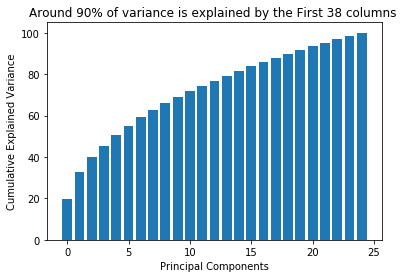

In [28]:
#using PCA to reduce number of dimensions/features
from sklearn.decomposition import PCA
pca = PCA(n_components = 25)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
cum_sum = pca.explained_variance_ratio_.cumsum()
cum_sum = cum_sum*100
plt.bar(range(25), cum_sum)
plt.ylabel("Cumulative Explained Variance")
plt.xlabel("Principal Components")
plt.title("Around 90% of variance is explained by the First 38 columns ")

In [29]:
#hyperparameter optimization with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
parameters = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
              {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]
search = GridSearchCV(SVC(), parameters, n_jobs=-1, verbose=1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\Ayushi Agarwal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.0s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']}, {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [30]:
#train SVM model
model = SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
    
model.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [31]:
#prediction
y_pred=model.predict(X_test)

In [32]:
#evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
print('Accuracy Score:',round(accuracy_score(y_test, y_pred),2))
#confusion matrix
cm = confusion_matrix(y_test, y_pred)


Accuracy Score: 0.89


Text(0.5, 257.44, 'Predicted label')

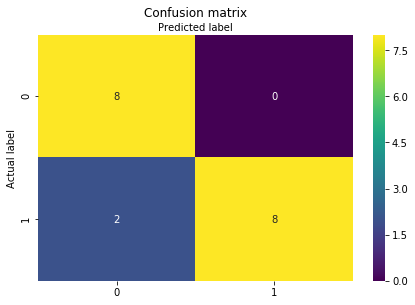

In [33]:
#Confusion matrix and visualize it using Heatmap.
class_names=[1,2,3]
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
class_names=['ALL', 'AML']
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="viridis" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')